# Machine Learning Engineer Nanodegree

In [10]:
# Print stuff inline
%matplotlib inline

# Imports
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import cross_validation
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# Load he data and drop columns we don't care about.
try:
    data = pd.read_csv("Amazon_Unlocked_Mobile.csv")
    data.drop(['Product Name', 'Brand Name','Price','Review Votes'], axis = 1, inplace = True)
    print "{} Amazon mobile phone reviews with {} features each.".format(*data.shape)
except:
    print "You need to download the dataset from https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones"

413840 Amazon mobile phone reviews with 2 features each.


In [3]:
data = data[data['Reviews'].isnull()==False]
ratings = data['Rating']
reviews = data['Reviews']

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
reviews = vectorizer.fit_transform(reviews)

In [5]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(reviews, ratings, test_size = 0.3)
print X_train.shape

(289644, 68242)


In [6]:
clf1 = MultinomialNB(alpha=0.0001).fit(X_train, y_train)

In [ ]:
clf2 = GradientBoostingClassifier().fit(X_train, y_train)

In [ ]:
clf3 = linear_model.LogisticRegression().fit(X_train, y_train)

In [ ]:
print(clf1.score(X_test, y_test))
print(clf3.score(X_test, y_test))

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(ratings)))
    plt.xticks(tick_marks, set(ratings), rotation=45)
    plt.yticks(tick_marks, set(ratings))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

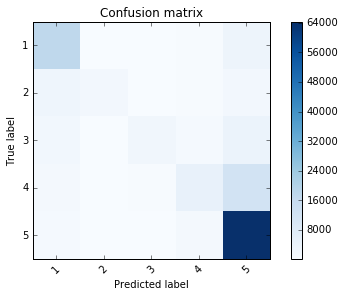

In [11]:
cm = confusion_matrix(y_test, clf1.predict(X_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm) 
plt.show()